In [1]:
import  tensorflow as tf 
from deepctr.inputs import  SparseFeat ,VarLenSparseFeat , DenseFeat
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
from  deepctr.inputs import get_feature_names 
from  deepctr.models import WDL
from sklearn.model_selection import train_test_split 
import tensorflow.keras as keras 
from sklearn.metrics import mean_squared_error

In [2]:
path  = './ml-100k.csv'
data = pd.read_csv(path ,encoding = 'utf-8')
print (list(data.columns))


['user_id', 'movie_id', 'rating', 'timestamp', 'age', 'gender', 'occupation', 'zip', 'genres']


In [3]:

sparse_categorical_features = ['user_id', 'movie_id' ,'gender', 'age',
                               'occupation', 'zip']
from sklearn.preprocessing import LabelEncoder
# 对特征标签进行编码
for feature in sparse_categorical_features:
    lbe = LabelEncoder()
    data[feature] = lbe.fit_transform(data[feature])

for  feature in sparse_categorical_features :
    print (data[feature].nunique())

943
1682
2
61
21
795


In [4]:
fixlen_feature_columns = [] 
for  feature in sparse_categorical_features:
    fixlen_feature_columns.append( SparseFeat(feature ,
                                data[feature].nunique() , 
                                embedding_dim = 4 ,use_hash =False  ))

In [5]:
def get_table(data ,feature_name , sep = '|'):
    s =set()
    for  line in  data[feature_name]:
        s.update( str(line).split(sep)) 
    s.add("<pad>")
    return  len(s) ,s 

In [6]:
max_len , table = get_table(data ,'genres' , sep = '|')

In [7]:
max_len

20

In [8]:
index2key ={  k :v   for  k ,v in enumerate( table)}

In [9]:
key2index  = { v:k for  k ,v   in index2key.items()}

In [10]:
key2index 

{'Sci-Fi': 0,
 'Documentary': 1,
 'Crime': 2,
 'Children': 3,
 'Drama': 4,
 'Romance': 5,
 'War': 6,
 'Thriller': 7,
 'Film-Noir': 8,
 'Fantasy': 9,
 'Adventure': 10,
 'Musical': 11,
 'nan': 12,
 'Comedy': 13,
 '<pad>': 14,
 'Mystery': 15,
 'Animation': 16,
 'unknown': 17,
 'Action': 18,
 'Horror': 19}

In [11]:
data['genres'] =data['genres'].astype(str).str.split("|").map( lambda line  :
                                  [  key2index[x]  for x  in line  ])

In [12]:
data['genres']

0                 [4]
1        [18, 13, 11]
2          [18, 4, 6]
3          [18, 4, 7]
4                 [4]
             ...     
99995             [4]
99996          [4, 5]
99997          [4, 5]
99998            [13]
99999          [2, 7]
Name: genres, Length: 100000, dtype: object

In [13]:
from tensorflow.keras.preprocessing.sequence import pad_sequences 

In [14]:
genres_list  = pad_sequences(data['genres']  ,
              maxlen=max_len,
                dtype=int,
                padding='post',
                value= key2index['<pad>'] ) 

In [15]:
 varlen_feature_columns = [VarLenSparseFeat(SparseFeat('genres', max_len ,
                                                       embedding_dim=4),
                                            maxlen=max_len,
                                            combiner='mean',
                                            weight_name=None)]

In [16]:
linear_feature_columns = fixlen_feature_columns + varlen_feature_columns
dnn_feature_columns = fixlen_feature_columns + varlen_feature_columns

feature_names = get_feature_names(linear_feature_columns+dnn_feature_columns)
feature_names

['user_id', 'movie_id', 'gender', 'age', 'occupation', 'zip', 'genres']

In [17]:
# 将数据集切分成训练集和测试集
train, test = train_test_split(data, test_size=0.2)
train_model_input = {name: train[name].values for name in feature_names}
test_model_input = {name: test[name].values for name in feature_names}
train_model_input['genres'] = genres_list[ :len(train) ,: ]
test_model_input ['genres'] = genres_list[ len(train): ,: ]
target = ['rating']

from tensorflow.keras.callbacks import EarlyStopping,TensorBoard
callbacks = [EarlyStopping( monitor='val_loss',patience=3, min_delta=1e-2)]

model = WDL(linear_feature_columns, 
            dnn_feature_columns, 
            task='regression' , 
            l2_reg_linear= 1e-5 ,
            l2_reg_embedding= 1e-5 ,
            l2_reg_dnn=0.01 , 
            init_std=0.0001,
            dnn_hidden_units=( 256, 128) ,
            seed=1024,
            dnn_dropout=0,
            dnn_activation='relu',
               )
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
genres (InputLayer)             [(None, 20)]         0                                            
__________________________________________________________________________________________________
user_id (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
movie_id (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
gender (InputLayer)             [(None, 1)]          0                                            
______________________________________________________________________________________________

In [18]:
from tensorflow.keras.optimizers import Adam 
optmizer = Adam(1e-4)
model.compile(optmizer , "mse", metrics=['mse'], )
history = model.fit(train_model_input, 
                    train[target].values,
                    batch_size=256,
                    epochs=20, 
                    verbose=True,
                    validation_split=0.2, )

Train on 64000 samples, validate on 16000 samples
Epoch 1/20


C:\ProgramData\Anaconda3\envs\tf2\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\ProgramData\Anaconda3\envs\tf2\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


64000/64000 [==============================] - 6s 89us/sample - loss: 10.5196 - mse: 8.6848 - val_loss: 3.1777 - val_mse: 1.5569
Epoch 2/20
64000/64000 [==============================] - 2s 28us/sample - loss: 2.5858 - mse: 1.1853 - val_loss: 2.3234 - val_mse: 1.1332
Epoch 3/20
64000/64000 [==============================] - 2s 30us/sample - loss: 2.0903 - mse: 1.0554 - val_loss: 1.9352 - val_mse: 1.0354
Epoch 4/20
64000/64000 [==============================] - 3s 42us/sample - loss: 1.7664 - mse: 0.9675 - val_loss: 1.6763 - val_mse: 0.9681
Epoch 5/20
64000/64000 [==============================] - 2s 32us/sample - loss: 1.5506 - mse: 0.9137 - val_loss: 1.5068 - val_mse: 0.9358
Epoch 6/20
64000/64000 [==============================] - 1s 17us/sample - loss: 1.4048 - mse: 0.8875 - val_loss: 1.3889 - val_mse: 0.9226
Epoch 7/20
64000/64000 [==============================] - 1s 22us/sample - loss: 1.2999 - mse: 0.8748 - val_loss: 1.3022 - val_mse: 0.9153
Epoch 8/20
64000/64000 [=============

<Figure size 576x576 with 0 Axes>

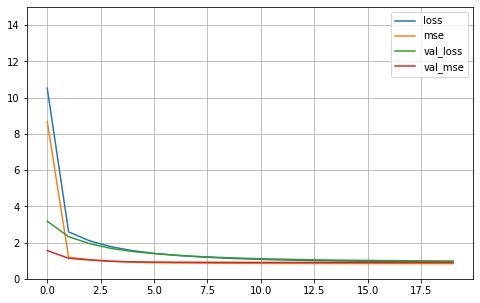

In [19]:
plt.figure( figsize= (8,8 ))
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 15)
    plt.show()
plot_learning_curves(history)

model.evaluate(test_model_input  ,
              test[target].values ,
              batch_size=256)

In [20]:
# 使用WDL进行预测
pred_ans = model.predict(test_model_input, batch_size=256)
# 输出RMSE或MSE
mse = round(mean_squared_error(test[target].values, pred_ans), 4)
rmse = mse ** 0.5
print("test RMSE", rmse)

test RMSE 0.9382430388763884
